In [14]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import fetch_data

In [15]:
class Portfolio:
    
    """For each trade, the object will buy or sell positions in the portfolio according how much is available. Passing
    0.5 to the object means that it will purchase 50% of all shares available (according to current balance and price). 
    Passing -0.5 to the object means that it will sell 50% of all shares available (according to how many it has). Sales
    are executed first, then purchase quantities are normalized according to the balance after the sales."""
    
    def __init__(self, stocks, balance_init=1_000_000, fee=0.001):
        
        assert isinstance(stocks, list) and len(stocks) >= 1
        assert balance_init >= 100
        assert fee >= 0
        
        self.stocks = [stock.lower() for stock in stocks]
        self.balance_init = balance_init
        self.fee = fee
        
    def reset(self):
        
        positions = {pos:0.0 for pos in self.stocks}
        self.positions_full = positions.copy() # Number of shares held for each stock
        self.positions_norm = positions.copy() # Portfolio exposure of each stock
        self.positions_norm['_out'] = 1.0 # Portfolio exposure includes none

        self.balance = self.balance_init # Liquidity in account
        self.net_worth = self.balance_init # liquidity + shares*prices
        
        self.days_passed = 0
        self.profits = []
        
        return self
        
    def make_trade(self, actions, prices):
        
        step = 1e-5
        assert isinstance(actions, dict)
        assert isinstance(prices, dict)
        
        net_worth_prev = self.net_worth
        sales = {stock:action for stock, action in actions.items() if action < 0}
        purchases = {stock:action for stock, action in actions.items() if action > 0}
        
        # Execute sales first
        for stock, action in sales.items():
            
            # How many shares are held
            total_possible = self.positions_full[stock]
            # Sell the specified portion of available held
            shares_sold = total_possible * -action
            # Profit is the price times quantity minus fee
            profit = shares_sold * prices[stock] * (1 - self.fee)

            self.positions_full[stock] -= shares_sold
            self.balance += profit
                
        # Adjust purchase allocations if necessary   
        if sum(purchases.values()) > 1:
            purchases = {
                k : v/sum(purchases.values())
                for k, v in purchases.items()
            }
  
        # Execute purchases
        balance = self.balance
        for stock, action in purchases.items():    
            
            # How many shares can be afforded
            total_possible = balance / (prices[stock]*(1+self.fee))
            # Buy specified amount of available shares
            shares_bought = total_possible * action
            # Cost is th eprices times the quantity plus fee
            cost = shares_bought * prices[stock] * (1 + self.fee)
            
            self.positions_full[stock] += shares_bought
            self.balance -= cost

        # Calculate net_worth
        self.net_worth = self.balance + sum(
            shares*price for shares, price 
            in zip(self.positions_full.values(), prices.values())
        )
        
        # Calculate exposures
        for position in self.positions_norm.keys():
            if position == '_out':
                self.positions_norm[position] = self.balance / self.net_worth
            else:
                self.positions_norm[position] = (self.positions_full[position]*prices[position]) / self.net_worth
                
        self.days_passed += 1
        self.profits.append(self.net_worth-net_worth_prev)
        
    def report(self):
        
        print('Balance:', round(self.balance, 5))
        print('Net worth:', self.net_worth)
        print('Shares held:', self.positions_full)
        print('Exposures:', self.positions_norm, '|', round(sum(self.positions_norm.values()), 5))
        
        try:
            print('Current profit:', self.profits[-1])
        except IndexError:
            print("Current profit: NA")
       
        try:
            print('Average profit:', sum(self.profits)/self.days_passed)
        except ZeroDivisionError:
            print("Average profit: NA")
       
        print('Total profit:', sum(self.profits))
        print('n Steps:', self.days_passed)
            
        return sum(self.profits)
    

In [16]:
class TradingEnvironment(gym.Env):
    
    """Initialize the backtesting/trading environment with a dictionary of Pandas dataframes. Takes action from agent 
    and manages portfolio accordingly. Keeps track of agent portfolio and buy-and-hold portfolio in order to calculate 
    rewards. Returns states that are normalized historical prices and account information."""
    
    metadata = {'render.modes': ['human']}

    def __init__(self, stocks, balance_init, training=True, train_size=0.8, fee=0.001):
        
        self.fee = fee
        self.balance_init = balance_init
        self.agent_portfolio = Portfolio(list(stocks.keys()), self.balance_init, self.fee)
        self.long_portfolio = Portfolio(list(stocks.keys()), self.balance_init, self.fee)
        
        self.stocks = {}
        for ticker, history in stocks.items():
            self.stocks[ticker] = history.copy()
            self.stocks[ticker]['date'] = pd.to_datetime(self.stocks[ticker]['date'])
            self.stocks[ticker].sort_values('date', inplace=True, ascending=False)

        self.training = training
        self.train_test_split = int(history.shape[0]*train_size)
        
        # Action space is equal to n_stocks. Each value corresponds to how much of a portfolio position to buy/sell
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(len(self.stocks), ))
        # Observation space is equal to 1 + 5*n_stocks. Will show OHLCV for past five days of each stock
        self.observation_space = gym.spaces.Box(low=0, high=np.inf, shape=( (len(self.stocks)*4), 3) )
        
    def _next_observation(self):
        
        full_observation = []
                
        for ticker, df in self.stocks.items():

            #max_vol = np.max(df.loc[self.current_step:self.first_step-5, 'volume'])
            #max_price = np.max(df.loc[self.current_step:self.first_step-5, ['high', 'low']])
            window = df.loc[self.current_step:self.first_step-5, ['high', 'low', 'volume']].copy()
            
            window[['high', 'low']] /= self.price_scalers[ticker]
            window['volume'] /= self.vol_scalers[ticker]
            window = window.values
            
            current = window[0]
            mean = np.mean(window[1:], axis=0)
            trend = np.array([
                (window[-1,0]-window[1,0]) / -5,
                (window[-1,1]-window[1,1]) / -5,
                (window[-1,2]-window[1,2]) / -5,
                ])
            meta = np.array([
                self.agent_portfolio.positions_norm[ticker],
                self.agent_portfolio.positions_norm[ticker]*self.agent_portfolio.net_worth,
                self.agent_portfolio.positions_full[ticker]/self.shares_held,
                ])
            
            full_observation.append(np.array([
                current, mean, trend, meta
                ]).reshape(4,3))

        full_observation = np.array(full_observation).reshape(len(self.stocks)*4, 3)
        assert full_observation.shape == self.observation_space.shape

        return full_observation
    
    def _take_action(self, actions):
        
        assert len(actions) == len(self.stocks)

        actions_long = {ticker:1 for ticker in self.stocks.keys()}
        prices = {ticker:df.loc[self.current_step, 'close'] for ticker, df in self.stocks.items()}
        
        self.agent_portfolio.make_trade(actions, prices)
        self.long_portfolio.make_trade(actions_long, prices)

        self.net_worth = self.agent_portfolio.net_worth
        self.balance = self.agent_portfolio.balance
        self.shares_held = max(1, sum(self.agent_portfolio.positions_full.values()), )        

    def step(self, action):
                
        self._take_action(action)
        self.current_step += 1
        
        # Done
        if self.training:
            done = (round(self.balance, 5) < 0 or self.current_step >= self.train_test_split-1)
        else:
            done = (round(self.balance, 5) < 0 or self.current_step >= self.df.shape[0]-1)
           
        # Obs
        obs = self._next_observation()

        # Reward
        profit_agent = self.agent_portfolio.net_worth - self.agent_portfolio.balance_init
        profit_long = self.long_portfolio.net_worth - self.long_portfolio.balance_init
        reward = (profit_agent - profit_long) / self.balance_init
        
        # Info
        info = {}
        
        return obs, reward, done, info
            
    def reset(self):
        
        if self.training: 
            self.current_step = 5
        else: 
            self.current_step = self.train_test_split
        self.first_step = self.current_step
        
        self.price_scalers = {ticker:df.loc[self.first_step, 'open'] for ticker, df in self.stocks.items()}
        self.vol_scalers = {ticker:df.loc[self.first_step, 'volume'] for ticker, df in self.stocks.items()}
        
        self.agent_portfolio.reset()
        self.long_portfolio.reset()
        
        self.net_worth = self.agent_portfolio.balance_init
        self.balance = self.agent_portfolio.balance_init
        self.shares_held = 1 
    
        return self._next_observation()
    
    def render(self, mode='human'):
        
        print('Current balance:', round(self.balance, 5))
        print('Current net worth:', self.net_worth)
        print('Shares held:', self.agent_portfolio.positions_full, round(self.shares_held, 5))
        print('Exposures:', self.agent_portfolio.positions_norm)
        print('Profit:', self.net_worth - self.balance_init)
               

---

In [17]:
df1 = fetch_data('fb_df')
df2 = fetch_data('aapl_df')
df3 = fetch_data('nflx_df')
df4 = fetch_data('goog_df')
df5 = fetch_data('sp500_df')

In [18]:
stocks = {'aapl':df2, 'nflx':df3, 'goog':df4}
#stocks = {'aapl':df2}
starting_balance = 1_000_000

env = TradingEnvironment(stocks, starting_balance)

In [20]:
done = False
obs = env.reset()
start = env.current_step

agent_performance = []
long_performance = []
rewards = []

while not done:
    
    agent_performance.append(env.agent_portfolio.net_worth)
    long_performance.append(env.long_portfolio.net_worth)
        
    actions = {'aapl':np.random.uniform(-1,1), 'nflx':np.random.uniform(-1,1), 'goog':np.random.uniform(-1,1)}
    #actions = {'aapl':1, 'nflx':1, 'goog':1}
    #actions = {'aapl':np.random.uniform(-1,1)}

    obs, reward, done, info = env.step(actions)
    
    rewards.append(reward)
    

In [21]:
dates = env.stocks['aapl'].loc[start:env.current_step-1:-1, 'date']

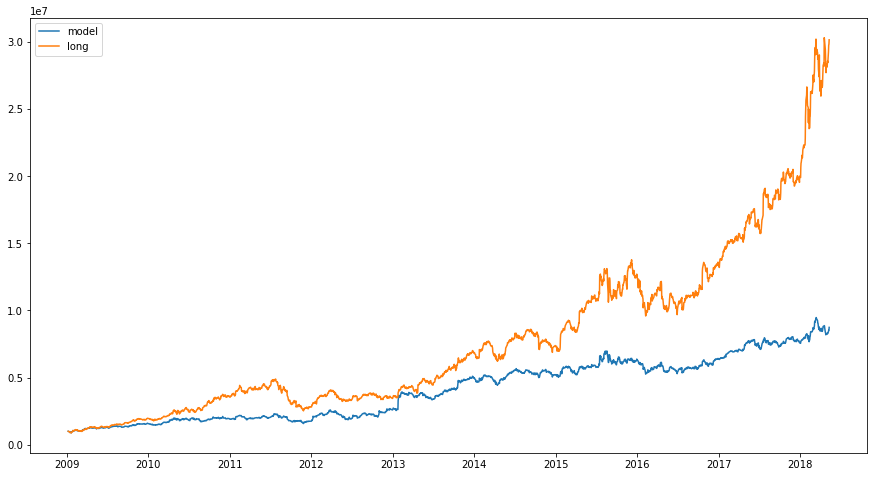

In [22]:
plt.figure(figsize=(15,8))
plt.plot(dates, agent_performance, label='model')
plt.plot(dates, long_performance, label='long')
plt.legend()

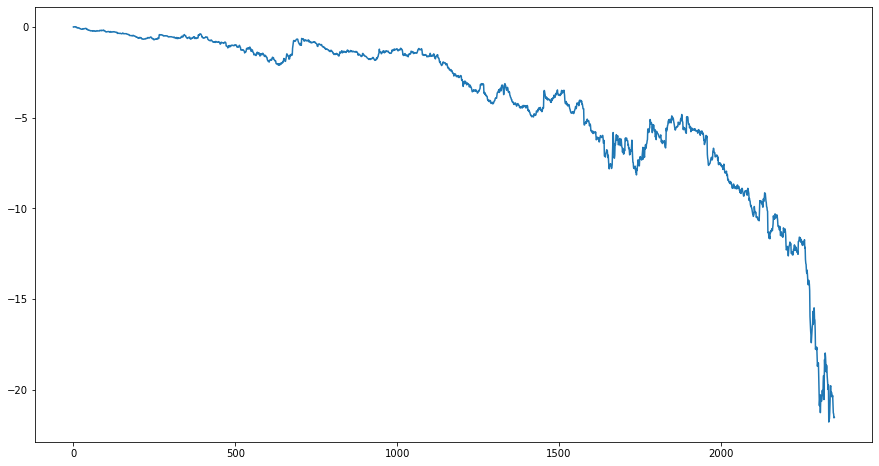

In [10]:
plt.figure(figsize=(15,8))
plt.plot(rewards)